## Exercise 1: Count-Trees (5 points)

Your task is to implement a count-tree with variable maximum history. It is a memory-efficient way to store n-gram counts which can also be used to create an intuitive back-off after the tree is pruned.

The tree object should support the following four operations:
- Increment a count of a specific n-gram (even if not present)
- Retrieve counts given the history (variable length)
- Retrieve the conditional probability of a word given the history. (Proportion count between branches)
- Pruning all nodes with counts less or equal to $k$

**1.1 (2 points)**

Make sure your implementation is correct by passing the asserts in the first code cell.

**1.2 (1 point)**

The next cell will incrementally add a quad-gram to the tree. Plot the perplexity of trigram language model (induced by this count tree) against the number of added n-grams. Comment on the curve shape. Smooth this language model with a zerogram distribution using a linear combination ($0.75\times p_4 + 0.25\times p_0$).

**1.3 (1 point)**

For the given range of thresholds, prune your tree and see how the threshold affects the performance. Plot the results (perplexity vs. threshold).

**1.4 (1 point)**

1. If you first prune with threshold $k_1$ and get tree $t_1$, then prune with $k_2$ and get $t_2$ what will be the relationship between $t_1$ and $t_2$ if $k_1 \ge k_2$? (0.25 points)
2. What is the memory benefit of count trees, in comparison to storing the counts as a dictionary `{n-gram:freq}`? (0.25 points)
3. If we pruned the tree so that only the first level is preserved, what distribution could we model with this tree? (0.25 points)
4. Pruning the count tree is said to be a dynamic way of smoothing the language model. Elaborate on how this smoothing happens. (0.25 points)

**Answers 1.4**

1. For tree $t1$ we will have lesser nodes compared to $t2$. Now n-grams sharing same history(present in the tree) but n-gram not present will be provided a pseudo count which would act as smoothing.

2. Count tree is memory effecient. With count trees, same history is present only once in memory with its corresponding count, but for dictionary, same history will be present all the times n-gram occurs.

3. When we will have have only one layer, then probability distribution becomes like this : $P(w_1,..w_n / w_1,...w_{n-1}) = C(w_n) / C(w_n - 1)$ where $C$ is the count function. Further we see it is dependent only on the count of the last two tokens of the n-gram. 

4. Yes, it is a dynamic way of smoothing.

In [32]:
from importlib import reload
import exercise_1
exercise_1 = reload(exercise_1)

import sys
sys.path.append('/content/data/alice_in_wonderland.txt')
sys.path.append('/content/exercise_1.py')

tree = exercise_1.CountTree(n=4)

assert tree.get("") == 0
tree.add("ABCE")
tree.add("ABCD")
tree.add("ABCD")
tree.add("QBCD")
tree.add("QQCD")
tree.add("BCDA")
tree.add("1234")
tree.add("1234")
tree.add("1234")
tree.add("1234")
tree.add("1234")
tree.add("5634")
assert tree.get("ABCD") == 2
assert tree.get("ABCX") == 0
assert tree.get("BCD") == 3
assert tree.get("D") == 4
assert tree.get("CD") == 4
assert tree.get("1234") == 5
assert tree.get("5634") == 1
tree.prune(4)
assert tree.get("ABCD") == 4
assert tree.get("XXCD") == 4
assert tree.get("D") == 4
assert tree.get("1234") == 5
assert tree.get("5634") == 1

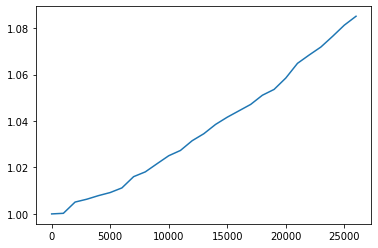

In [33]:
import matplotlib.pyplot as plt

plot_x = []
plot_y = []

ngrams = []
tree = exercise_1.CountTree(n=4)
with open("/content/data/alice_in_wonderland.txt", "r") as f:
  tokens = f.read().lower().split()
  for i in range(len(tokens)-4):
    ngrams.append(tokens[i:i+4])

vocab = set(tokens)
for i,ngram in enumerate(ngrams):
  tree.add(ngram)
  if i % 1000 == 0:
    plot_x.append(i)
    plot_y.append(tree.perplexity(ngrams, vocab))

plt.plot(plot_x, plot_y)

[1, 2, 3, 4, 5, 10, 25, 50, 75, 100]
[1.086053479519519, 1.0263567403995828, 1.0119030269366438, 1.0030047011148526, 1.0003161292397378, 0.9976643901733325, 1.0014839387087633, 1.0021067662480476, 1.0047578548709355, 1.0035994553932723]


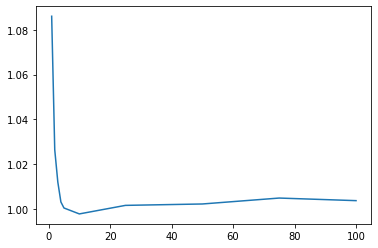

In [34]:
plot_x = []
plot_y = []

for threshold in [1,2,3,4,5,10,25,50,75,100]:
  tree.prune(threshold)
  plot_x.append(threshold)
  plot_y.append(tree.perplexity(ngrams, vocab))

print(plot_x)
print(plot_y)

plt.plot(plot_x, plot_y)

## Exercise 2: Kneser-Ney Smoothing (5 points)

This exercise aims to provide a basic understanding of Kneser-Ney Smoothing. Kneser-Ney Smoothing makes use of *continuation counts* of words for lower order n-grams, given as

\begin{equation}
C_{KN} = 
\begin{cases}
\text{count}(\bullet) & \text{for highest order} \\
\text{continuationcount}(\bullet) & \text{for lower orders}
\end{cases}
\end{equation}


For a trigram distribution, Kneser-Ney Smoothing is implemented using the following equations:

$$P_{KN}(w_3|w_1, w_2) = \frac{\max\{N(w_1 w_2 w_3)-d,0\}}{N(w_1 w_2)} + \lambda(w_1, w_2)P_{KN}(w_3|w_2)$$

$$P_{KN}(w_3|w_2) = \frac{\max\{N_{+}(\bullet w_2 w_3)-d,0\}}{N_{+}(\bullet w_2 \bullet)} + \lambda(w_2)P_{KN}(w_3)$$

\begin{equation}
P_{KN}(w_3) = \begin{cases}
\frac{N_{+}(\bullet w_3)}{N_{+}(\bullet \bullet)} & \text{if $w_3 \in$ V} \\
\frac{1}{V} & \text{otherwise}
\end{cases}
\end{equation}

$\lambda$ is used to normalise the discounted probability mass and is given by

$$\lambda(w_1, w_2) = \frac{d}{N(w_1 w_2)} \cdot N_{+}(w_1 w_2 \bullet)$$

$$\lambda(w_2) = \frac{d}{N(w_2)} \cdot N_{+}(w_2 \bullet)$$

**2.1 (4.5 points)**

* Your first task is to understand what these terms represent and fill it in the table below (4-5 words each).

* Create a trigram-level model on the given text, `alice_in_wonderland.txt`. Write your implementation in the file `exercise_2.py`. Preprocess the text by punctuation removal, lowercasing, and tokenisation. There is no need to split the data into train and test sets. (0.5 points)

In [46]:
import sys
sys.path.append('/content/data/alice_in_wonderland.txt')
sys.path.append('/content/exercise_2.py')

from importlib import reload
import exercise_2
exercise_2 = reload(exercise_2)

file = open("/content/data/alice_in_wonderland.txt", "r")
text = file.read()

# TODO: Preprocess text
tokens = exercise_2.preprocess(text)

* 
Write a simple class `KneserNey` in `exercise_2` that calculates the different parameters required for finding the trigram conditional probability. You may modify the function signature and add other functionality as required. <br/>
Now, consider the trigrams `"alice said nothing"` and `"alice said nichts"`. For these trigrams, estimate the values mentioned in the table given below and fill in the obtained results. The discounting parameter *d* = 0.75. (3 points)

In [47]:
KN_model = exercise_2.KneserNey(tokens, d=0.75, N=3)

t1 = "alice said nothing"
t2 = "alice said nichts"

# TODO
# Get the required parameters
print(" Params for t1 ")
KN_model.get_params(t1)

print("\n Params for t2 ")
KN_model.get_params(t2)

 Params for t1 
 N+(∙∙) =  14716
 N+(∙w3) =  23
 N+(∙w2∙) =  319
 N+(∙w2w3) =  5
 N(w2) =  462
 N+(w2∙) =  56
 N(w1w2) =  11
 N(w1w2w3) =  2
 N+(w1w2∙) =  11
 λ(w2) =  0.09090909090909091
 λ(w1w2) =  0.75
 
 Calculating the probabilities:
 PKN(w3) =  0.0003633720930232558
 PKN(w3|w2) =  0.013355917839177663
 PKN(w3|w1,w2) =  0.12365330201574688

 Params for t2 
 N+(∙∙) =  14716
 N+(∙w3) =  0
 N+(∙w2∙) =  319
 N+(∙w2w3) =  0
 N(w2) =  462
 N+(w2∙) =  56
 N(w1w2) =  11
 N(w1w2w3) =  0
 N+(w1w2∙) =  11
 λ(w2) =  0.09090909090909091
 λ(w1w2) =  0.75
 
 Calculating the probabilities:
 PKN(w3) =  0.0003633720930232558
 PKN(w3|w2) =  3.30338266384778e-05
 PKN(w3|w1,w2) =  2.4775369978858354e-05


| Term in Kneser-Ney |   Value t1  | Value t2 | Description | 
|---|---|---| --- |
|$N(w_1w_2w_3)$| 2 | 0 | Total frequency of word $(w_1 w_2 w_3)$ |
|$N(w_1 w_2)$| 11 | 11 | Total frequency of word $(w_1 w_2)$ |
|$N_{+}( \bullet w_2 w_3)$| 5 | 0 | Number of types of words preceding $w_2 w_3$ |
|$N_{+}( \bullet w_2 \bullet)$| 319 | 319 | Number of types of words preceding  and following $w_2$ |
|$N_{+}( \bullet w_3)$| 23 | 0 | Number of types of words preceding $w_3$  |
|$N_{+}( \bullet \bullet)$| 14716 | 14716 | Number of types of bigram words |
|$N_{+}(w_1 w_2 \bullet)$| 11 | 11 | Number of types of words following $w_1 w_2$ |
|$N_{+}(w_2 \bullet)$| 56 | 56 | Number of types of words following $w_2$ |
|$\lambda(w_1 w_2)$| 0.75 | 0.75 | Normalized discount paramter |
|$\lambda(w_2)$| 0.09090909090909091 | 0.09090909090909091 | Normalized discount paramter |

* Using the values obtained above, manually calculate $P_{KN}(w_3)$, $P_{KN}(w_3|w_2)$, and $P_{KN}(w_3|w_1, w_2)$ for the given trigrams. (1 point)

**Answer**

*Probabilities for t1:*

$PKN(w3) =  0.0003633720930232558$ \
$PKN(w3|w2) =  0.013355917839177663$ \
$PKN(w3|w1,w2) =  0.12365330201574688$ \

*Probabilities for t2:*

$PKN(w3) =  0.0003633720930232558$ \
$PKN(w3|w2) =  3.30338266384778e-05$ \
$PKN(w3|w1,w2) =  2.4775369978858354e-05$ \


**2.2 (0.5 points)**

Take a look at this [video](https://www.youtube.com/watch?v=cbAxvpBFyNU) on Kneser-Ney smoothing by Dan Jurafksy. Make sure to undestand his *San Francisco* example. <br/>
How will Kneser-Ney Smoothing handle the following bigrams (answer in 3-4 sentences)? 

* Abu Dhabi

* Game Over


**Answer 2.2**

Kneser-Ney Smoothing is better estimate for probabilties of low order n-grams. Given bigrams "Abu Dhabi" and "Game Over" can appear several times in the training corpus and hence the frequency of unigrams "Dhabi" and "Over" will also be high. Relying on only the frequency of 
unigram to predict the frequency of n-gram can give distorted results. Kneser-Ney smoothing rectify this by considering the frequency of bigrams completed by the given unigram or the number of types of word preceding the unigram.

## Bonus (2 points)

For each of the smoothing techniques below,

1. Laplace/add-1 smoothing (0.3 points)
2. Add-$\alpha$ smoothing (0.3 points)
3. Linear interpolation (0.3 points)
4. Absolute discounting (0.3 points)
5. Good-Turing (0.3 points)
6. Kneser-Ney smoothing (0.3 point)

* Give the intuition behind it
* State at least one drawback and
* Explain how the ensuing smoothing technique accounts for this drawback.

You can do so in continuous text or in bullet points. Write 3-5 sentences for each technique. For Kneser-Ney smoothing, you should suggest *and explain* an improved version from the literature, e.g. [here](http://nrs.harvard.edu/urn-3:HUL.InstRepos:25104739) (this tutorial may also be helpful for the rest of the exercise).

Please note that while the points for this bonus exercise are the immediate motivation, your self-made comparison will be highly beneficial for the exam.

## Bonus : Answers

For each of the smoothing techniques below,

1. Laplace/add-1 smoothing

- Intuition - To ensure our posterior probabilities are never zero, for which we assume every seen or unseen token occurs once more than it did in the training set.
- $ P(w_i) = \_frac{C(w_i + 1)}{N + V} $ where $N$ is number of Tokens in Training Set and $V$ is the Vocabulary Size
- Drawback: Using $\alpha = 1$, we are assigning too much Probability mass to the Unseen tokens
- Enuring Smoothing Technique causes the LM to assume the frequency on the unseen words to be more than expected, hence higher probability to assign these unseen token as the next probable word. $w_1$

2. Add-$\alpha$ smoothing 
    - Intuition: To ensure our posterior probabilities are never zero, for which we assume every seen or unseen token occurs slightly more time than zero. Generally value of $\alpha$ is in the range $0 < \alpha < 1$. This is done to avoid assigning too much Probability mass to unseen tokens.
    - $P(w_i) = \frac{C(w_i + \alpha)}{N + V*\alpha}$
    - Drawback: Using $0 <\alpha < 1$, we are assigning more Probability to the unseen tokens as compared to the original
    - Enuring Smoothing Technique causes the LM to assume the frequency on the unseen words to be more than expected, hence higher probability to assign these unseen token as the next probable word.

3. Good-Turing
    - Intuition: Redistributing the probability mass of $n$-grams that occur $r + 1$ times in the training data to the $n$-grams that occur $r$ times.
    - Adjust Counting    
    \begin{equation}
    N^*(w,h) = \begin{cases}
    [N(w,h) + 1]\frac{n_{N(w,h)+1}}{n_{N(w,h)}} & \text{for $N(w,h) <= 5$} \\
    N(w,h) & \text{otherwise}
    \end{cases}
    \end{equation}
    - $P(w|h) = \frac{N^*(w,h)}{N(h)} + \lambda(h)\beta(w|h)$
    - Drawback: If $n_{r+1} = 0$, then it causes holes in the count.
    - Enuring Smoothing Technique causes amplification of this noise in our training corpus

4. Linear interpolation
    - Intuition: To solve the sparseness in the above models is by mixing the trigram model with the bigram and unigram models
    - $P_li(w_n|w_{n-2},w_{n-1}) = \lambda_1 P_1(w_n) + \lambda_2 P_2(w_n|w_{n-1}) +\lambda_3 P_3(w_n|w_{n-1},w_{n-2})$
    
    where $0 <= \lambda_i <= 1$ and $\sum_i \lambda_i = 1$ 
    - Drawback: Tuning all the $\lambda$'s make it very hard to implement this model
    - Enuring Smoothing Technique causes assuming the closest proximity value for $\lambda$ then calculating the precised values.

5. Absolute discounting
    - Intuition: Here rather than multiplying by higher order probability with $\lambda$, we subtract $\delta$ from each non zero count
    \begin{equation}
    P_{abs}(w_1,...,w_n) = \begin{cases}
    \frac{r-\delta}{N} & \text{if $r > 0$} \\
    \frac{(B-N_0)\delta}{N_0N} & \text{otherwise}
    \end{cases}
    \end{equation}
    where B is the number of bins
    - Drawback: it does not take into account for those tokens which are mostly seen as bigram, such as "New York"
    - Enuring Smoothing Technique causes we will have to feed such tokens in the Corpus as one word, else this exception is not taken into account during approximation, we will have to take lower order backing off into account during approximation 

6. Kneser-Ney smoothing
    - Intuition: Here we consider the words with their context an extention to absolute discounting and find the probability distribution as per the common history of the word. For Example "San Francisco", using Absolute Discounting “Francisco” will get a higher unigram probability irrespective of the history, but using Kneser-Ney smoothing will give a lower unigram Probability to “Francisco”, as it is more common that it occurs after “San”.
    - Modified Kneser-Ney Smoothing: Here rather than using a single discount for all non-zero Counts, this method uses 3 different Discount Parameters $D_1, D_2 and D_3+$, which are applied to one, two and three or more counts to n-gram at each level probability.
    - $P_{KN}(w_i|w^{i-1}_{i-n+1}) = \frac{c(w^i_{i-n+1}) - D(c(w^i_{i-n+1}))}{\sum_{wi}c(w^i_{i-n+1})} \gamma(w^i_{i-n+1})P_{KN}(w^i|w^{i-1}_{i-n+2})$
      
    \begin{equation}
    D(c) = \begin{cases}
    0 & \text{if $c = 0$} \\
    D_1 & \text{if $c = 1$} \\
    D_2 & \text{if $c = 2$} \\
    D_3 & \text{if $c >= 3$} 
    \end{cases}
    \end{equation}
    - The modified Kneser Ney Smoothing performs better than the standard in bigram and trigram corpus and over all training set size. And it has similar performance for other corpora. The performance of both is very close, but for larger training set Modified version consistently outperforms the standard version.